In [1]:
# Importing required libraries
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

In [14]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

imb_2019 = pd.read_csv("../data/imbalance_2019_modeling.csv", index_col=0, parse_dates=['timestamp'], date_parser=dateparse)
imb_2020 = pd.read_csv("../data/imbalance_1h_2020.csv", index_col=0, parse_dates=['timestamp'], date_parser=dateparse)

In [141]:
def fill_missing(data):
    data = data.resample('1H').median()
    data = data.interpolate(method='time', limit_direction='both')
    return data

In [16]:
imb_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        8760 non-null   datetime64[ns]
 1   imbalance_price  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 205.3 KB


In [17]:
imb_2019.head()

,timestamp,imbalance_price
0,2019-01-01 00:00:00,-329.6045
1,2019-01-01 01:00:00,-283.8000
2,2019-01-01 02:00:00,-334.7170
3,2019-01-01 03:00:00,117.6665
4,2019-01-01 04:00:00,-323.3150


In [19]:
imb_2019 = imb_2019.set_index('timestamp')

In [5]:
def train_test_split(df):
    n = int(len(df)*0.7)
    train, test = df.iloc[:n], df.iloc[n:]

    return train,test

In [20]:
train_2019, test_2019 = train_test_split(imb_2019)
#train_2020, test_2020 = train_test_split(imb_2020)

In [7]:
print(train_2019.shape, test_2019.shape)
#print(train_2020.shape, test_2020.shape)

(6132, 2) (2628, 2)


In [137]:
#train_2019_nooutlier = train_2019[(train_2019 >= train_2019.quantile(0.05)) & (train_2019 <= train_2019.quantile(0.95))]

In [22]:
def kpss_test(ts):
    """
    Performs a KPSS test for the null hypothesis of stationarity.
    
        Args:
        ts: 1d time series
        
        Returns:
        Summary of test statistic and critical values
    """
    print ('Results of KPSS Test:')
    kpsstest = kpss(ts, regression='c', nlags='legacy')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

def adf_test(ts):
    """
    Performs a Dickey-Fuller test for the null hypothesis of
    non-stationarity.
    
        Args:
        ts: 1-d time series
    
        Returns:
        Printed test statistic and critical values.
    """
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [23]:
kpss_test(train_2019)

Results of KPSS Test:
Test Statistic            0.547825
p-value                   0.030895
Lags Used                34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [24]:
adf_test(train_2019)

Results of Dickey-Fuller Test:
Test Statistic                -1.035203e+01
p-value                        2.522099e-18
#Lags Used                     2.600000e+01
Number of Observations Used    6.105000e+03
Critical Value (1%)           -3.431422e+00
Critical Value (5%)           -2.862014e+00
Critical Value (10%)          -2.567022e+00
dtype: float64


kpss and adf results are contradictory one reason for that is the data is not stationary. Lets take a difference with the first lag and check again kpss and adf tests

In [25]:
def take_diff(df):
    diff = df - df.shift(1)
    diff.dropna(inplace=True)

    return diff


In [26]:
diff_train_2019 = take_diff(train_2019)

In [27]:
diff_train_2019.head()

,imbalance_price
timestamp,
2019-01-01 01:00:00,45.8045
2019-01-01 02:00:00,-50.9170
2019-01-01 03:00:00,452.3835
2019-01-01 04:00:00,-440.9815
2019-01-01 05:00:00,262.8470


In [28]:
kpss_test(diff_train_2019)

Results of KPSS Test:
Test Statistic            0.006717
p-value                   0.100000
Lags Used                34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [29]:
adf_test(diff_train_2019)

Results of Dickey-Fuller Test:
Test Statistic                  -20.490764
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6096.000000
Critical Value (1%)              -3.431423
Critical Value (5%)              -2.862014
Critical Value (10%)             -2.567022
dtype: float64


We can see now after substracting with its first lag, both kpss and adf tests varify that the data is now stationary. This also indicate the d value in ARIMA should be fix to 1.

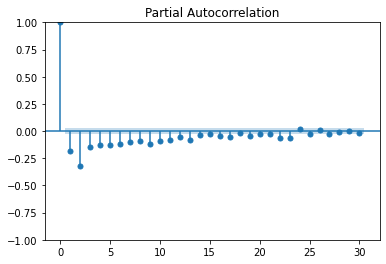

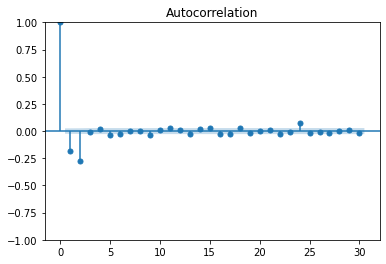

In [30]:
plot_pacf(diff_train_2019, lags=30, alpha=0.05)
plot_acf(diff_train_2019, lags=30, alpha=0.05);

Conclusion : AR (2), MA (4?)

In [31]:
p_range = range(1,4)
d_range = [0,1]
q_range = range(2,6)

In [32]:
def best_aic(df, p_range, d_range, q_range):
    aic = []
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p,d,q)
                model = ARIMA(df, order=order)
                model_fit = model.fit()
                aic.append([order, model_fit.aic])
                print(order, model_fit.aic)
    return aic

In [33]:
aic = best_aic(train_2019, p_range, d_range, q_range)

(1, 0, 2) 92244.1435538929
(1, 0, 3) 92224.86608597118
(1, 0, 4) 92222.28812330471
(1, 0, 5) 92206.84815108229
(1, 1, 2) 92254.80322806287
(1, 1, 3) 92233.50202784597
(1, 1, 4) 92223.58783836095
(1, 1, 5) 92230.31189823494
(2, 0, 2) 92221.24270727523
(2, 0, 3) 92213.20973460676
(2, 0, 4) 92216.83037948402
(2, 0, 5) 92211.66657444858
(2, 1, 2) 92246.27306655215
(2, 1, 3) 92248.08941281744
(2, 1, 4) 92222.2420634552
(2, 1, 5) 92231.14400188992
(3, 0, 2) 92218.57046918066
(3, 0, 3) 92213.3085893085
(3, 0, 4) 92204.5567118691
(3, 0, 5) 92212.66883630143
(3, 1, 2) 92226.53800060926
(3, 1, 3) 92234.78399916836
(3, 1, 4) 92232.51652774599
(3, 1, 5) 92225.46957930135


best parameters (3,0,4)

aic_stored = [ (1, 1, 9) 218438.0776477024,
(1, 1, 10) 218438.01246079954,
(1, 1, 11) 218440.0511899708,
(1, 1, 29) 218340.04531203417,
(1, 1, 30) 218338.54849014725,
(1, 1, 31) 218340.52428676168,
(1, 2, 9) 218564.85978435766,
(1, 2, 10) 218549.11981467105,
(1, 2, 11) 218444.7523995524,
(1, 2, 29) 218378.39439223066,
(1, 2, 30) 218372.16868848068,
(1, 2, 31) 218375.07940818206,
(2, 1, 9) 218441.75412751187,
(2, 1, 10) 218432.7815369026,
(2, 1, 11) 218442.93800884116,
(2, 1, 29) 218345.72706959496,
(2, 1, 30) 218338.1428312349,
(2, 1, 31) 218337.6654606091,
(2, 2, 9) 218559.46220384608,
(2, 2, 10) 218544.80879750013,
(2, 2, 11) 218535.00113799973,
(2, 2, 29) 218387.8264022952
(3, 1, 31) 218347.48071973433,]

### Best ARIMA model so far
aic = best_aic(train_2019, 3,0,4)

In [39]:
train_2019

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150
...,...
2019-09-13 07:00:00,210.0060
2019-09-13 08:00:00,-461.1385
2019-09-13 09:00:00,-107.5935


In [47]:
pd.DataFrame(test_2019.iloc[i]).T

,imbalance_price
2019-09-13 16:00:00,283.303


In [89]:
train_modified = train_2019.copy()

In [88]:
for i in range(5):
    #train.append(pd.DataFrame(test_2019.iloc[i]).T, ignore_index=True)
    train1 = pd.concat([train1, pd.DataFrame(test_2019.iloc[i]).T])
    #print(train1)
    #print(pd.DataFrame(test_2019.iloc[i]).T)


In [95]:
len(forecasts_1h)

97

In [91]:
#for i in range(len(test_2019)):
forecasts_1h = []
for i in range(len(test_2019)):
    train_modified = pd.concat([train_modified, pd.DataFrame(test_2019.iloc[i]).T])
    model_1h = ARIMA(train_modified, order=(2,1,6))
    model_1h_fit = model_1h.fit()
    forecast_1h = model_1h_fit.forecast(steps=1)
    print(forecast_1h)
    forecasts_1h.append(forecast_1h)
    if i == 96:
        break

6158   -308.760983
dtype: float64
6159   -354.907648
dtype: float64
6160   -221.425791
dtype: float64
6161    36.538921
dtype: float64
6162    25.703236
dtype: float64
6163   -100.064425
dtype: float64
6164    165.803589
dtype: float64
6165   -291.782063
dtype: float64
6166   -208.295756
dtype: float64
6167   -346.078947
dtype: float64
6168   -106.438957
dtype: float64
6169   -120.555171
dtype: float64
6170    113.038504
dtype: float64
6171   -89.373939
dtype: float64
6172    3.462026
dtype: float64
6173   -109.429534
dtype: float64
6174   -295.785567
dtype: float64
6175   -141.927002
dtype: float64
6176   -309.423988
dtype: float64
6177   -384.021975
dtype: float64
6178   -524.211509
dtype: float64
6179   -237.216677
dtype: float64
6180    88.073947
dtype: float64
6181   -221.733523
dtype: float64
6182   -212.337234
dtype: float64
6183   -201.021199
dtype: float64
6184   -361.943333
dtype: float64
6185   -32.066829
dtype: float64
6186   -311.80951
dtype: float64
6187   -252.047778
dty

In [92]:
train_modified

,imbalance_price
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150
...,...
2019-09-17 08:00:00,-1007.0595
2019-09-17 09:00:00,456.2235
2019-09-17 10:00:00,0.3400
2019-09-17 11:00:00,348.0760


In [96]:
forecast_1h_df = train_modified.iloc[-98:-1]
forecast_1h_df['predicted'] = np.array(forecasts_1h)

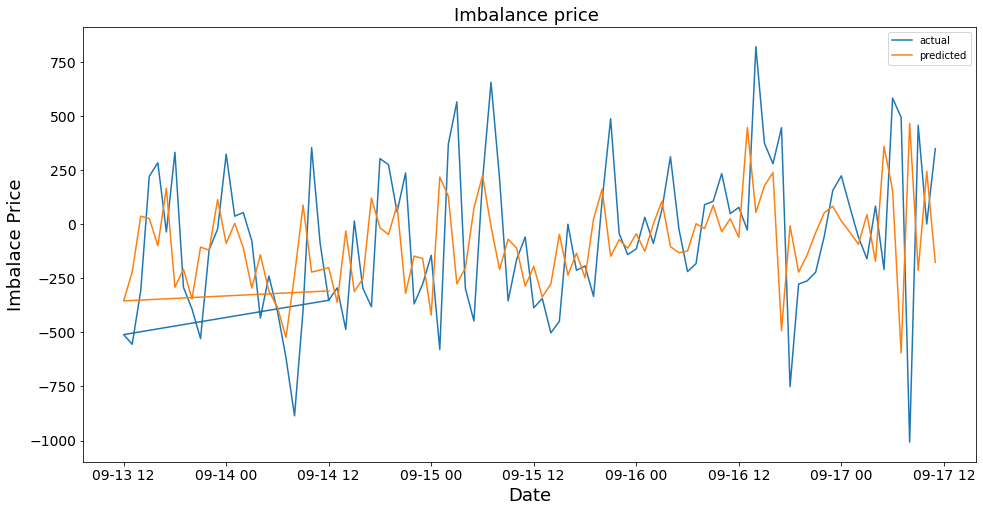

In [98]:
plt.figure(figsize=(16, 8))
#plt.plot(train_2019.iloc[-250:-98], label='train')
plt.plot(forecast_1h_df['imbalance_price'], label='actual')
plt.plot(forecast_1h_df['predicted'], label='predicted')
plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Imbalace Price', fontsize=18)
plt.title('Imbalance price ', fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);
plt.savefig('imb_price_train_test_arima_1h.png')

In [155]:
np.sqrt(mean_squared_error(forecast_1h_df['imbalance_price'].values, forecast_1h_df['predicted'].values))

313.15765054356456

In [ ]:
train_2019.iloc[-150:-25]

In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error())

In [28]:
#for i in range(len(test_2019)):
forecasts_6h = []
for i in range(0,24,6):
    model_6h = ARIMA(train_2019.iloc[:-(25-i),:], order=(2,1,7))
    model_6h_fit = model_6h.fit()
    forecast_6h = model_6h_fit.forecast(steps=6)
    print(forecast_6h)
    forecasts_6h.append(forecast_6h.values)

2020-08-17 15:00:00    457.938858
2020-08-17 16:00:00    215.031158
2020-08-17 17:00:00    186.804066
2020-08-17 18:00:00    154.360982
2020-08-17 19:00:00    110.536118
2020-08-17 20:00:00    105.468761
Freq: H, Name: predicted_mean, dtype: float64
2020-08-17 21:00:00      7.779984
2020-08-17 22:00:00    125.419474
2020-08-17 23:00:00    131.720098
2020-08-18 00:00:00    108.379550
2020-08-18 01:00:00    120.265317
2020-08-18 02:00:00    121.496040
Freq: H, Name: predicted_mean, dtype: float64
2020-08-18 03:00:00   -12.578646
2020-08-18 04:00:00    26.210504
2020-08-18 05:00:00    48.630590
2020-08-18 06:00:00    75.986324
2020-08-18 07:00:00    80.562780
2020-08-18 08:00:00    82.297769
Freq: H, Name: predicted_mean, dtype: float64
2020-08-18 09:00:00   -142.857622
2020-08-18 10:00:00    -43.296123
2020-08-18 11:00:00    -17.782585
2020-08-18 12:00:00     24.525237
2020-08-18 13:00:00     46.281686
2020-08-18 14:00:00     49.894842
Freq: H, Name: predicted_mean, dtype: float64


In [29]:
forecasts_6h = np.array(forecasts_6h).reshape(24,1)

In [30]:
forecast_6h_df = train_2019.iloc[-25:-1]
forecast_6h_df['predicted'] = np.array(forecasts_6h)

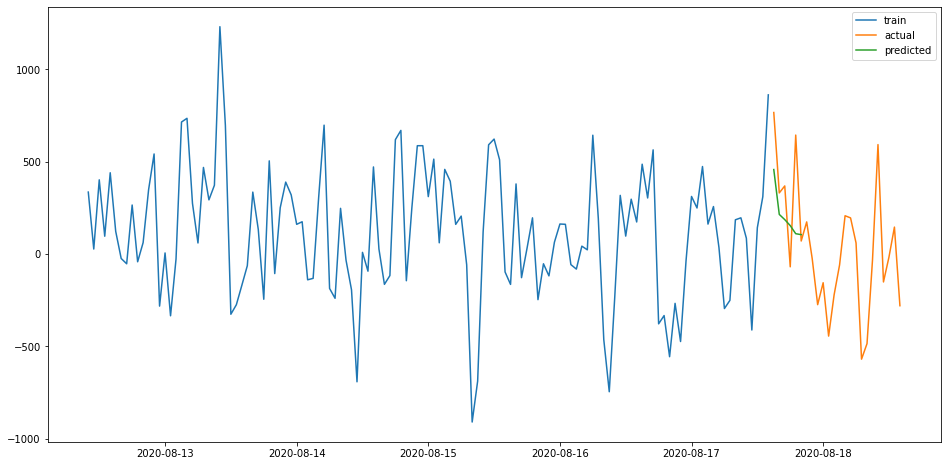

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[:6], label='predicted')
plt.legend()

Index(['fiftyhertz', 'tennet', 'amprion', 'transnetbw', 'nrv'], dtype='object')

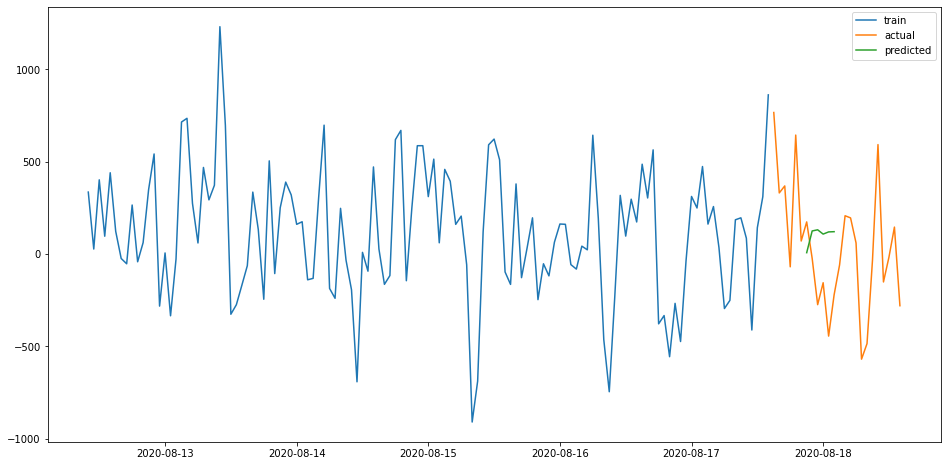

In [32]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[6:12], label='predicted')
plt.legend()

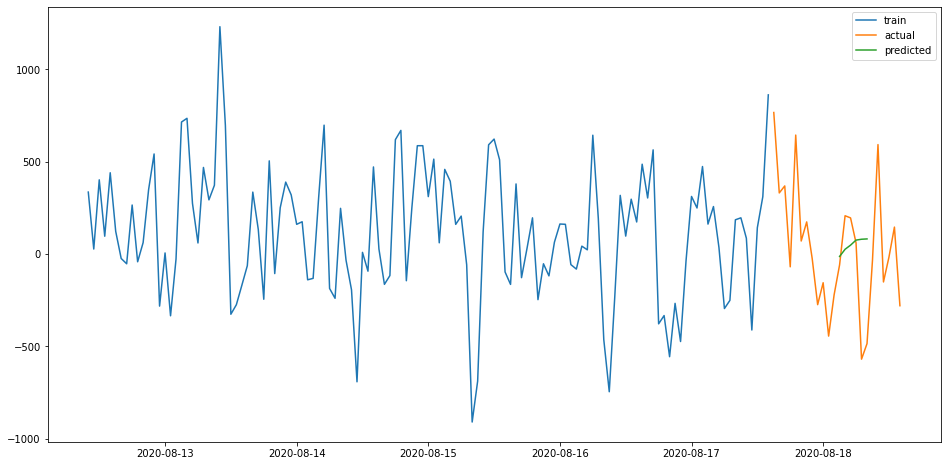

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[12:18], label='predicted')
plt.legend()

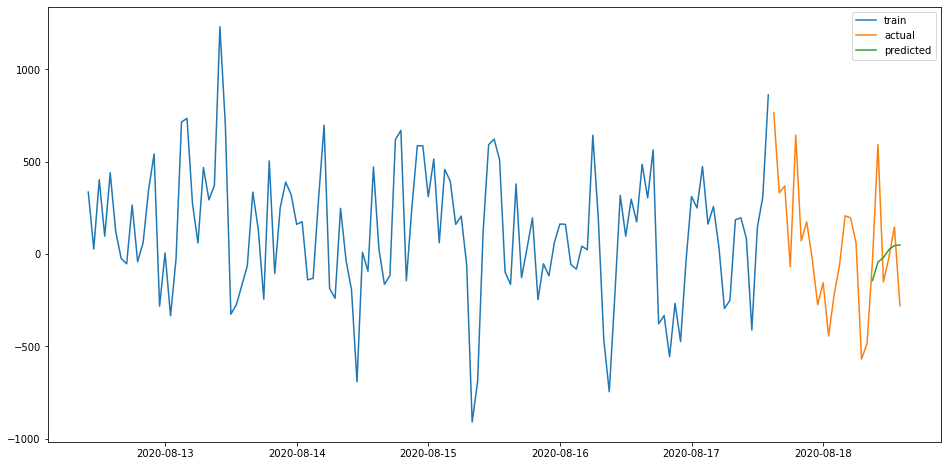

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[18:], label='predicted')
plt.legend()

In [ ]:
# or parameters of the model (fit_intercept for Linear Regression model)
mlflow_params = {
      "p": fitted_model.params,
      "d": ,
      "q": ,
  }

In [ ]:
# logging params to mlflow
mlflow.log_params(params)
# setting tags
mlflow.set_tag("model", "ARIMA")
mlflow.set_tag("features", "imbalance price")
# logging metrics
mlflow.log_metric("test-" + "RMSE", rmse)
mlflow.log_metric("test-" + "R2", rsquared)
# end run
mlflow.end_run()

In [ ]:
plt.figure(figsize=(14,6))
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals, label='residuals')
#plt.plot(train_2019, label= 'original', alpha=0.5)
plt.legend()

## Without outliers

In [139]:
train_2019_nooutlier = train_2019[(train_2019 >= train_2019.quantile(0.05)) & (train_2019 <= train_2019.quantile(0.95))]

In [142]:
train_2019_nooutlier.head()

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150


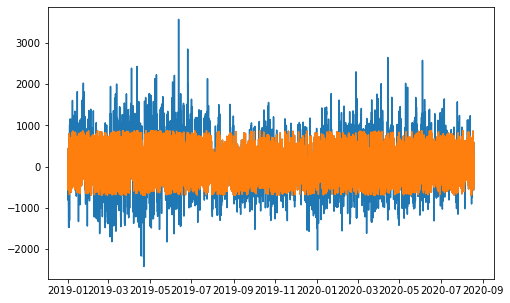

In [166]:
plt.figure(figsize=(8,5))
plt.plot(train_2019)
plt.plot(train_2019_nooutlier)

In [143]:
train_2019_nooutlier = fill_missing(train_2019_nooutlier)

In [144]:
train_2019_nooutlier

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150
...,...
2020-08-18 11:00:00,-150.6755
2020-08-18 12:00:00,-16.4735
2020-08-18 13:00:00,146.3290


In [145]:
kpss_test(train_2019_nooutlier)

Results of KPSS Test:
Test Statistic            1.233565
p-value                   0.010000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [146]:
adf_test(train_2019_nooutlier)

Results of Dickey-Fuller Test:
Test Statistic                -1.569009e+01
p-value                        1.437384e-28
#Lags Used                     3.000000e+01
Number of Observations Used    1.426500e+04
Critical Value (1%)           -3.430808e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [149]:
diff_train_2019_nooutlier = take_diff(train_2019_nooutlier)

In [150]:
kpss_test(diff_train_2019_nooutlier)

Results of KPSS Test:
Test Statistic            0.002075
p-value                   0.100000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [151]:
adf_test(diff_train_2019_nooutlier)

Results of Dickey-Fuller Test:
Test Statistic                   -28.716000
p-value                            0.000000
#Lags Used                        42.000000
Number of Observations Used    14252.000000
Critical Value (1%)               -3.430809
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


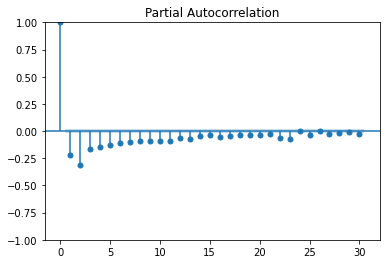

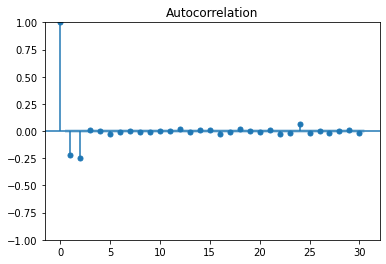

In [152]:
plot_pacf(diff_train_2019, lags=30, alpha=0.05)
plot_acf(diff_train_2019, lags=30, alpha=0.05);

In [156]:
#for i in range(len(test_2019)):
forecasts_1h_nooutlier = []
for i in range(24):
    model_1h_nooutlier = ARIMA(train_2019_nooutlier.iloc[:-(25-i),:], order=(2,1,6))
    model_1h_fit_nooutlier = model_1h_nooutlier.fit()
    forecast_1h_nooutlier = model_1h_fit_nooutlier.forecast(steps=1)
    print(forecast_1h_nooutlier)
    forecasts_1h_nooutlier.append(forecast_1h_nooutlier)

2020-08-17 15:00:00    413.767378
Freq: H, dtype: float64
2020-08-17 16:00:00    344.820749
Freq: H, dtype: float64
2020-08-17 17:00:00    190.612087
Freq: H, dtype: float64
2020-08-17 18:00:00    217.200977
Freq: H, dtype: float64
2020-08-17 19:00:00    21.701165
Freq: H, dtype: float64
2020-08-17 20:00:00    368.968817
Freq: H, dtype: float64
2020-08-17 21:00:00    62.772299
Freq: H, dtype: float64
2020-08-17 22:00:00    180.215036
Freq: H, dtype: float64
2020-08-17 23:00:00    35.936889
Freq: H, dtype: float64
2020-08-18   -32.638875
Freq: H, dtype: float64
2020-08-18 01:00:00    2.062458
Freq: H, dtype: float64
2020-08-18 02:00:00   -135.788368
Freq: H, dtype: float64
2020-08-18 03:00:00   -28.193423
Freq: H, dtype: float64
2020-08-18 04:00:00    10.324714
Freq: H, dtype: float64
2020-08-18 05:00:00    134.084868
Freq: H, dtype: float64
2020-08-18 06:00:00    112.348211
Freq: H, dtype: float64
2020-08-18 07:00:00    65.309703
Freq: H, dtype: float64
2020-08-18 08:00:00   -212.63237

In [158]:
forecast_1h_nooutlier_df = train_2019.iloc[-25:-1]
forecast_1h_nooutlier_df['predicted'] = np.array(forecasts_1h_nooutlier)

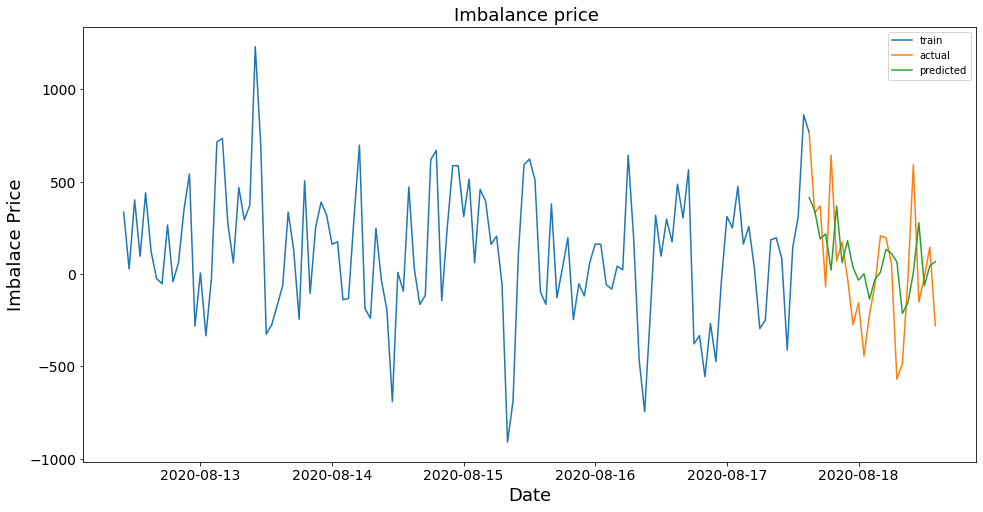

In [159]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-24], label='train')
plt.plot(forecast_1h_nooutlier_df['imbalance_price'], label='actual')
plt.plot(forecast_1h_nooutlier_df['predicted'], label='predicted')
plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Imbalace Price', fontsize=18)
plt.title('Imbalance price ', fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);


In [161]:
np.sqrt(mean_squared_error(forecast_1h_nooutlier_df['imbalance_price'].values, forecast_1h_nooutlier_df['predicted'].values))

308.3407719901207

## SHORTER DATA

In [179]:
train_2019

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150
...,...
2020-08-18 11:00:00,-150.6755
2020-08-18 12:00:00,-16.4735
2020-08-18 13:00:00,146.3290


In [186]:
train_jan = train_2019[(train_2019.index >= '2019-01-01 00:00:00') & (train_2019.index < '2019-02-01 00:00:00')]
train_feb = train_2019[(train_2019.index >= '2019-02-01 00:00:00') & (train_2019.index < '2019-03-01 00:00:00')]
train_june = train_2019[(train_2019.index >= '2019-06-01 00:00:00') & (train_2019.index < '2019-08-01 00:00:00')]
train_sep = train_2019[(train_2019.index >= '2019-09-01 00:00:00') & (train_2019.index < '2019-11-01 00:00:00')]
train_oct = train_2019[(train_2019.index >= '2019-10-01 00:00:00') & (train_2019.index < '2019-12-01 00:00:00')]

In [190]:
kpss_test(train_jan)

Results of KPSS Test:
Test Statistic            0.221805
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [193]:
kpss_test(train_oct)

Results of KPSS Test:
Test Statistic            0.103878
p-value                   0.100000
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [192]:
adf_test(train_jan)

Results of Dickey-Fuller Test:
Test Statistic                -9.234495e+00
p-value                        1.644381e-15
#Lags Used                     2.000000e+00
Number of Observations Used    7.410000e+02
Critical Value (1%)           -3.439206e+00
Critical Value (5%)           -2.865448e+00
Critical Value (10%)          -2.568851e+00
dtype: float64


In [194]:
adf_test(train_oct)

Results of Dickey-Fuller Test:
Test Statistic                -1.232007e+01
p-value                        6.782405e-23
#Lags Used                     4.000000e+00
Number of Observations Used    1.459000e+03
Critical Value (1%)           -3.434840e+00
Critical Value (5%)           -2.863523e+00
Critical Value (10%)          -2.567826e+00
dtype: float64


In [198]:
dif_train_jan = take_diff(train_jan)
dif_train_june = take_diff(train_june)

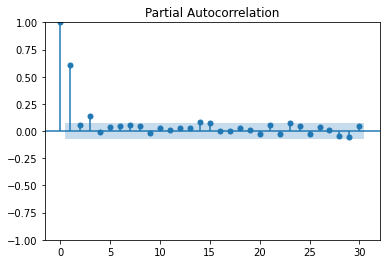

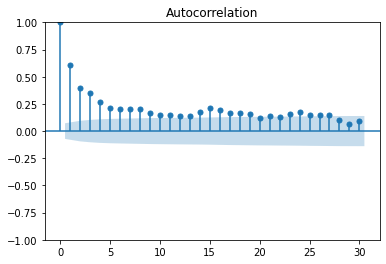

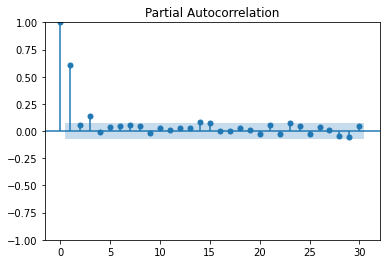

In [236]:
plot_acf(train_jan, lags=30, alpha=0.05)
plot_pacf(train_jan, lags=30, alpha=0.05)

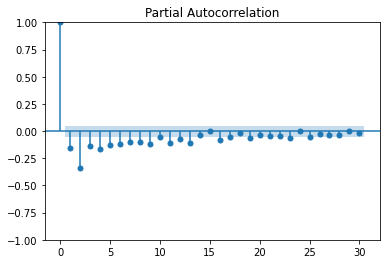

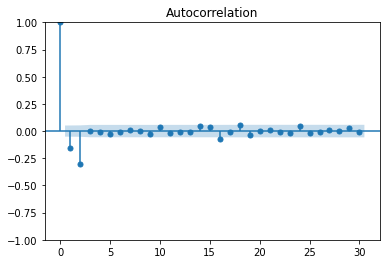

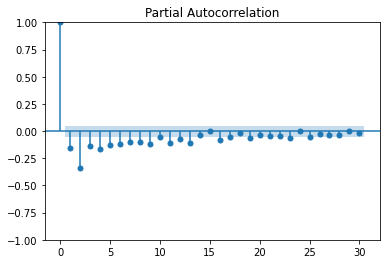

In [199]:
plot_acf(dif_train_june, lags=30, alpha=0.05)
plot_pacf(dif_train_june, lags=30, alpha=0.05)

In [200]:
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)

In [201]:
aic_jan = best_aic(train_jan, p_range, d_range, q_range)


(1, 1, 1) 11055.577832263341
(1, 1, 2) 11057.457718835736
(1, 1, 3) 11054.863367386844
(2, 1, 1) 11057.504953375894
(2, 1, 2) 11056.494818028848
(2, 1, 3) 11054.913106656233
(3, 1, 1) 11053.43501773107
(3, 1, 2) 11054.09639853087
(3, 1, 3) 11055.790833047906


all values of p,d,q more or less provides same aic


In [205]:
forecasts_1h_jan = []
for i in range(24):
    model_1h_jan = ARIMA(train_jan.iloc[:-(25-i),:], order=(1,1,1))
    model_1h_fit_jan = model_1h_jan.fit()
    forecast_1h_jan = model_1h_fit_jan.forecast(steps=1)
    print(forecast_1h_jan)
    forecasts_1h_jan.append(forecast_1h_jan)

2019-01-30 23:00:00    237.438938
Freq: H, dtype: float64
2019-01-31    533.236246
Freq: H, dtype: float64
2019-01-31 01:00:00    314.945466
Freq: H, dtype: float64
2019-01-31 02:00:00    328.583232
Freq: H, dtype: float64
2019-01-31 03:00:00    351.563912
Freq: H, dtype: float64
2019-01-31 04:00:00    286.48941
Freq: H, dtype: float64
2019-01-31 05:00:00    275.06384
Freq: H, dtype: float64
2019-01-31 06:00:00    606.429349
Freq: H, dtype: float64
2019-01-31 07:00:00    404.254345
Freq: H, dtype: float64
2019-01-31 08:00:00    294.272081
Freq: H, dtype: float64
2019-01-31 09:00:00   -287.646844
Freq: H, dtype: float64
2019-01-31 10:00:00    148.519254
Freq: H, dtype: float64
2019-01-31 11:00:00    252.226136
Freq: H, dtype: float64
2019-01-31 12:00:00    242.970699
Freq: H, dtype: float64
2019-01-31 13:00:00   -100.481019
Freq: H, dtype: float64
2019-01-31 14:00:00   -123.27056
Freq: H, dtype: float64
2019-01-31 15:00:00    693.460748
Freq: H, dtype: float64
2019-01-31 16:00:00    852

In [221]:
forecasts_1h_jan

[2019-01-30 23:00:00    237.438938
 Freq: H, dtype: float64,
 2019-01-31    533.236246
 Freq: H, dtype: float64,
 2019-01-31 01:00:00    314.945466
 Freq: H, dtype: float64,
 2019-01-31 02:00:00    328.583232
 Freq: H, dtype: float64,
 2019-01-31 03:00:00    351.563912
 Freq: H, dtype: float64,
 2019-01-31 04:00:00    286.48941
 Freq: H, dtype: float64,
 2019-01-31 05:00:00    275.06384
 Freq: H, dtype: float64,
 2019-01-31 06:00:00    606.429349
 Freq: H, dtype: float64,
 2019-01-31 07:00:00    404.254345
 Freq: H, dtype: float64,
 2019-01-31 08:00:00    294.272081
 Freq: H, dtype: float64,
 2019-01-31 09:00:00   -287.646844
 Freq: H, dtype: float64,
 2019-01-31 10:00:00    148.519254
 Freq: H, dtype: float64,
 2019-01-31 11:00:00    252.226136
 Freq: H, dtype: float64,
 2019-01-31 12:00:00    242.970699
 Freq: H, dtype: float64,
 2019-01-31 13:00:00   -100.481019
 Freq: H, dtype: float64,
 2019-01-31 14:00:00   -123.27056
 Freq: H, dtype: float64,
 2019-01-31 15:00:00    693.460748
 

In [225]:
def plot_forecast(train_df, forecast_list):
    forecast_df = train_df.iloc[-25:-1]
    forecast_df['predicted'] = np.array(forecast_list)
    print(forecast_df)

In [232]:
def plot_forecast(train_df, forecast_list):
    forecast_df = train_df.iloc[-25:-1]
    forecast_df['predicted'] = np.array(forecast_list)
    #print(forecast_df)

    #ploting
    plt.figure(figsize=(16, 8))
    plt.plot(train_df.iloc[-150:-24], label='train')
    plt.plot(forecast_df['imbalance_price'], label='actual')
    plt.plot(forecast_df['predicted'], label='predicted')
    plt.legend()
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Imbalace Price', fontsize=18)
    plt.title('Imbalance price ', fontsize=18)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    mse =mean_squared_error(forecast_df['imbalance_price'].values, forecast_df['predicted'].values)
    print('rmse = ', np.sqrt(mse));

rmse =  463.9450344170957


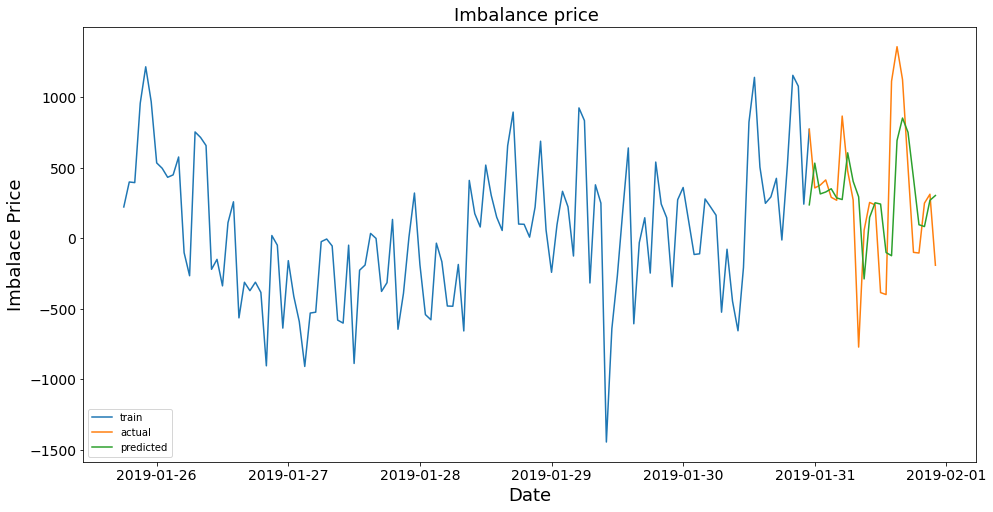

In [233]:
plot_forecast(train_jan,  forecasts_1h_jan)

In [203]:
aic_jun = best_aic(train_june, p_range, d_range, q_range)

(1, 1, 1) 22128.92797987238
(1, 1, 2) 22089.745905851956
(1, 1, 3) 22096.0832110964
(2, 1, 1) 22104.727758684814
(2, 1, 2) 22089.272992844883
(2, 1, 3) 22092.992132836207
(3, 1, 1) 22087.60115253723
(3, 1, 2) 22088.12102178006
(3, 1, 3) 22092.201768152583


1,1,2 could be selected as the best values for p,d,q respectively 

In [206]:
forecasts_1h_june = []
for i in range(24):
    model_1h_june = ARIMA(train_june.iloc[:-(25-i),:], order=(1,1,2))
    model_1h_fit_june = model_1h_june.fit()
    forecast_1h_june = model_1h_fit_june.forecast(steps=1)
    print(forecast_1h_june)
    forecasts_1h_june.append(forecast_1h_june)

2019-07-30 23:00:00   -137.970909
Freq: H, dtype: float64
2019-07-31   -96.261106
Freq: H, dtype: float64
2019-07-31 01:00:00   -1.91021
Freq: H, dtype: float64
2019-07-31 02:00:00   -225.891652
Freq: H, dtype: float64
2019-07-31 03:00:00   -64.85471
Freq: H, dtype: float64
2019-07-31 04:00:00    4.778478
Freq: H, dtype: float64
2019-07-31 05:00:00   -338.306357
Freq: H, dtype: float64
2019-07-31 06:00:00   -211.352263
Freq: H, dtype: float64
2019-07-31 07:00:00   -72.346669
Freq: H, dtype: float64
2019-07-31 08:00:00   -31.265422
Freq: H, dtype: float64
2019-07-31 09:00:00   -419.480241
Freq: H, dtype: float64
2019-07-31 10:00:00    241.727187
Freq: H, dtype: float64
2019-07-31 11:00:00   -49.365468
Freq: H, dtype: float64
2019-07-31 12:00:00   -273.879919
Freq: H, dtype: float64
2019-07-31 13:00:00   -433.212419
Freq: H, dtype: float64
2019-07-31 14:00:00   -301.582006
Freq: H, dtype: float64
2019-07-31 15:00:00   -119.556753
Freq: H, dtype: float64
2019-07-31 16:00:00   -127.969346


rmse =  499.5747031426609


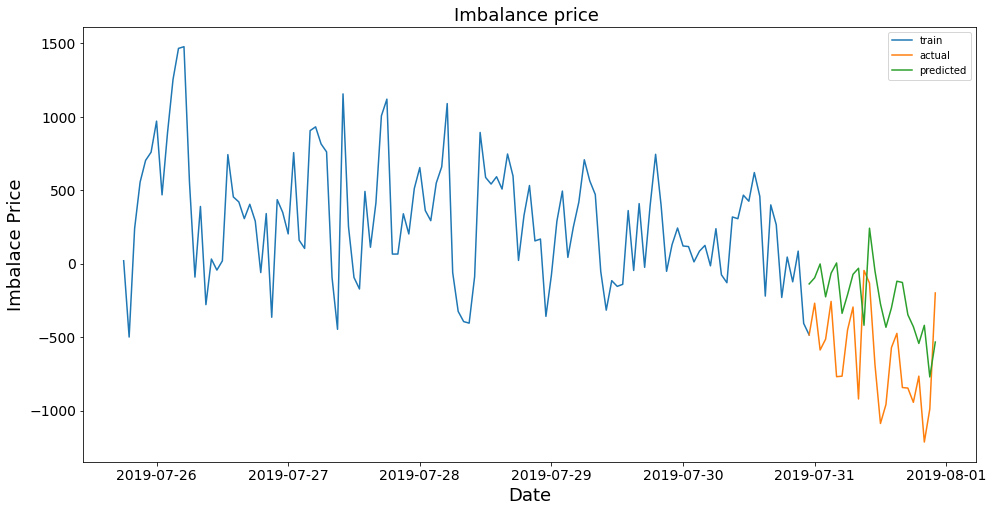

In [234]:
plot_forecast(train_june,  forecasts_1h_june)

In [204]:
aic_sep = best_aic(train_sep, p_range, d_range, q_range)

(1, 1, 1) 21364.138999860428
(1, 1, 2) 21352.742411707306
(1, 1, 3) 21354.052205521963
(2, 1, 1) 21361.085414714504
(2, 1, 2) 21350.092184739904
(2, 1, 3) 21340.92892678044
(3, 1, 1) 21340.815614810188
(3, 1, 2) 21342.479233996954
(3, 1, 3) 21342.96056297978


best parameters : 2,1,3

In [207]:
forecasts_1h_sep = []
for i in range(24):
    model_1h_sep = ARIMA(train_sep.iloc[:-(25-i),:], order=(2,1,3))
    model_1h_fit_sep = model_1h_sep.fit()
    forecast_1h_sep = model_1h_fit_sep.forecast(steps=1)
    print(forecast_1h_sep)
    forecasts_1h_sep.append(forecast_1h_sep)

2019-10-30 23:00:00   -8.699789
Freq: H, dtype: float64
2019-10-31    147.048144
Freq: H, dtype: float64
2019-10-31 01:00:00    131.49213
Freq: H, dtype: float64
2019-10-31 02:00:00    109.386027
Freq: H, dtype: float64
2019-10-31 03:00:00    81.338464
Freq: H, dtype: float64
2019-10-31 04:00:00    41.356263
Freq: H, dtype: float64
2019-10-31 05:00:00   -10.294113
Freq: H, dtype: float64
2019-10-31 06:00:00   -41.558671
Freq: H, dtype: float64
2019-10-31 07:00:00   -55.251596
Freq: H, dtype: float64
2019-10-31 08:00:00    110.626009
Freq: H, dtype: float64
2019-10-31 09:00:00   -14.039709
Freq: H, dtype: float64
2019-10-31 10:00:00   -156.127926
Freq: H, dtype: float64
2019-10-31 11:00:00   -195.875361
Freq: H, dtype: float64
2019-10-31 12:00:00   -269.730576
Freq: H, dtype: float64
2019-10-31 13:00:00   -71.737084
Freq: H, dtype: float64
2019-10-31 14:00:00   -38.008621
Freq: H, dtype: float64
2019-10-31 15:00:00   -126.025412
Freq: H, dtype: float64
2019-10-31 16:00:00   -71.130381
F

rmse =  372.00844408927736


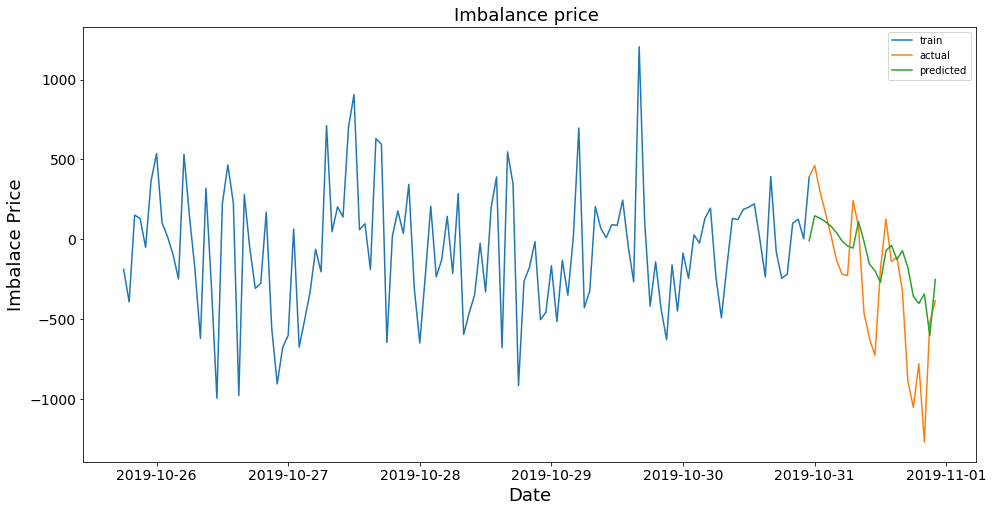

In [235]:
plot_forecast(train_sep,  forecasts_1h_sep)